## IMPORT Necessary libraries

In [39]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

## Select model file and set labels

In [40]:
modelPath = '../Model/test4.h5'
classifier = load_model(modelPath)
labels = ['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','x', 'y']

## FOR CANVAS SELECTION

In [41]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

class InputPrompt:

    def __init__(self):
        self.width = 1400
        self.height = 500
        self.center = self.height // 2
        self.white = (255, 255, 255)
        self.green = (0, 128, 0)
        self.cv, self.draw, self.image1 = '', '', ''
        self.openTheCanvas()


    def save(self):
        self.path = "canvas_image.png"
        self.image1.save(self.path)

    def paint(self, event):
        # python_green = "#476042"
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        self.cv.create_oval(x1, y1, x2, y2, fill="black", width=0.5)
        self.draw.line([x1, y1, x2, y2], fill="black", width=10)

    def openTheCanvas(self):

        root = Tk()

        # Tkinter create a canvas to draw on
        self.cv = Canvas(root, width=self.width, height=self.height, bg='white')
        self.cv.pack()

        # PIL create an empty image and draw object to draw on
        # memory only, not visible
        self.image1 = PIL.Image.new("RGB", (self.width, self.height), self.white)
        self.draw = ImageDraw.Draw(self.image1)

        # do the Tkinter canvas drawings (visible)
        # cv.create_line([0, center, width, center], fill='green')

        self.cv.pack(expand=YES, fill=BOTH)
        self.cv.bind("<B1-Motion>", self.paint)

        # do the PIL image/draw (in memory) drawings
        # draw.line([0, center, width, center], green)

        # PIL image can be saved as .png .jpg .gif or .bmp file (among others)
        # filename = "my_drawing.png"
        # image1.save(filename)
        button = Button(text="save", command=self.save)
        button.pack()
        root.mainloop()


from tkinter import filedialog

class FileChooser:

    def __init__(self):
        root = Tk()
        root.filename = filedialog.askopenfilename(initialdir="/", title="Select file",
                                                   filetypes=(("jpeg files", "*.jpg"), ("all files", "*.*")))
        self.path=root.filename


## Choose file or draw the image

In [42]:
while(True):
    p=int(input("Enter 1 to draw and 2 to select Image"))
    if(p==1):
        obj=InputPrompt()
        break
    elif(p==2):
        obj=FileChooser()
        break
    

Enter 1 to draw and 2 to select Image1


## Open the file and always save it in png format

In [43]:
from PIL import Image
givenImagePath = obj.path

im = Image.open(givenImagePath)
im.save('temp.png')


## Image Segmentation

In [44]:
    im = cv2.imread('temp.png')
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)
    ret, im_th = cv2.threshold(im_gray, 150, 255, cv2.THRESH_BINARY_INV)
    _, ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    images = {}
    x = 0
    for rect in rects:
        cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)
        leng = int(rect[3] * 1.5)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        if(leng<=28):
            roi = im_th[pt1-14:pt1 + leng+14, pt2-14:pt2 + leng+14]
        else:
            roi = im_th[pt1:pt1 + leng, pt2:pt2 + leng]
        images[rect[0]] = roi
        

In [45]:
    import cv2
    y = 0
    positionWithImages = {}
    for key in sorted(images):
        img2=cv2.cvtColor(images[key],cv2.COLOR_GRAY2RGB)
        positionWithImages[y]=img2
        y+=1
        
        

## Resizing  PIL images

In [46]:
from resizeimage import resizeimage
def resizeImages(pilImage):
    width, height = pilImage.size
    size = (28, 28)

    if width>=28 and height>=28:


         resizedImage = resizeimage.resize_cover(pilImage, size)
         a=np.array(resizedImage)
#          cv2.imwrite('y' + x.__str__() + '.jpg', a)
         return a
    else:
         return None

## Predict by giving a array

In [47]:
def predictFromArray(arr):
    result = classifier.predict(arr)
    for i in range(len(result[0])):
       if(result[0][i]>0.75):
           return (labels[i])

## Run predictions on the segmented images

In [48]:
mainEquation=[]
for i in range(len(positionWithImages)):
    pilImaged=Image.fromarray(positionWithImages[i])
    x=resizeImages(pilImaged)
    arr = np.expand_dims(x, axis=0)
#     print(arr.shape)
    equation=predictFromArray(arr)
    mainEquation.append(equation)

## EQUATION SOLVER CLASS

In [49]:
from sympy import *

class Solver:

    def __init__(self, equation):
        self.equation = str(equation)
        self.leftEqu = []

    def convertEquationIntoGeneralForm(self):

        leftSide, rightSide = '', ''
        equalIndx = self.equation.index('=')
        leftSide = self.equation[0:equalIndx]
        rightSide = self.equation[equalIndx+1:len(self.equation)]

        if rightSide[0].isalpha() or rightSide[0].isdigit():
            rightSide = '+' + rightSide

        for i in range(0, len(rightSide)):
            if rightSide[i] == '+':
                rightSide = rightSide[0:i] + '-' + rightSide[i+1:len(rightSide)]
            elif rightSide[i] == '-':
                rightSide = rightSide[0:i] + '+' + rightSide[i+1:len(rightSide)]
            leftSide += rightSide[i]

        self.equation = leftSide + '=' + '0'
        print('Final Equation is {}'.format(self.equation))
        self.leftEqu = leftSide

    def solveEquation(self):

        self.convertEquationIntoGeneralForm()
        sympy_eq = sympify("Eq(" + self.equation.replace("=", ",") + ")")
        roots = solve(sympy_eq)
        print(roots)

import numpy
from matplotlib import pyplot as plt

class Graph:

    def __init__(self, equation):
        self.graphEquation = 'y = ' + self.yToX(equation)
        self.equation = equation + '+'
        self.confirmAllCoefficient()
        self.convertEquStringToInt()
        x = numpy.linspace(-10, 10, 100)
        y = self.getTheFunction(x)
        self.drawGraph(x, y)

    def yToX(self, equation_param):
        equation_y = equation_param
        for i in range(0, len(equation_y)):
            if equation_y[i].isalpha() and equation_y[i] == 'y':
                equation_y = equation_y[0:i] + 'x' + equation_y[i+1:len(equation_y)]
        return equation_y

    def drawGraph(self, x, y):
        plt.plot(x, y)
        plt.ylabel("y")
        plt.xlabel("x")
        plt.title(self.graphEquation)
        plt.show()

    def confirmAllCoefficient(self):
        if self.equation[0].isalpha() or self.equation[0].isdigit():
            self.equation = '+' + self.equation
        tempEqu = ''
        for i in range(0, len(self.equation)):
            condition = self.equation[i].isalpha()
            condition &= not self.equation[i-1].isdigit()
            condition &= not self.equation[i-1] == '*'
            if condition:
                tempEqu += '1'
                tempEqu += '*'
            tempEqu += self.equation[i]
        self.equation = tempEqu
        print('With Coefficient Expression = {}'.format(self.equation))

    def getTheFunction(self, x):
        y = 0
        for i in range(0, len(self.equation)):
            if isinstance(self.equation[i], int) and not self.equation[i-1] == '*':
                sign = 1 if self.equation[i - 1] == '+' else -1
                if not self.equation[i+1] == '*':
                    y += sign * self.equation[i]
                else:
                    if self.equation[i+3] == '*':
                        power = self.equation[i+5]
                        y += sign * self.equation[i] * (x**power)
                    else:
                        y += sign * self.equation[i] * x
        return y

    def convertEquStringToInt(self):
        temporary = []
        i = 0
        while i < len(self.equation):
            if self.equation[i].isdigit():
                start, end = i, -1
                for k in range(start+1, len(self.equation)):
                    if not self.equation[k].isdigit():
                        end = k
                        break
                temporary.append(int(self.equation[start:end]))
                i += (end-start)-1
            else:
                temporary.append(self.equation[i])
            i += 1
        print('Temporary List = {}'.format(temporary))
        self.equation = temporary



# -7+3*x**2+5*x-x**2=6*x+x**2+11+6*x
# -x**4+12-3*x**2=2*x-10
# 7-3*x**2-5*x+x**2=-6*x-x**2-11-6*x

## Reconstruct the equation

In [50]:

concatenatedString=""
for i in range(len(mainEquation)):
    a=mainEquation[i]
    if(a.isdigit()==False and a.isalpha()==False):
        if(a==mainEquation[i+1]=='-'):
            concatenatedString+='='
        else:
            concatenatedString+=a
    if(a.isalpha()==True):
        if(i>0):
            if(mainEquation[i-1].isdigit()):
                concatenatedString+="*"+a
            else:
                concatenatedString+=a
        else:
            concatenatedString+=a
    if(a.isdigit()==True):
        if(i>0):
            if(mainEquation[i-1].isdigit()):
                concatenatedString+=a
            elif(mainEquation[i-1].isalpha()):
                concatenatedString+="^"+a
            else:
                concatenatedString+=a
        else:
            concatenatedString+=a
            
l=list(concatenatedString)   
for i in range(len(l)):
    if(l[i]=="="):
        newStr=l[:i+1]+l[i+2:]

equ=""
for i in newStr:
    equ+=i

    
    
print(equ)


x^2-2=0



## Show results

Final Equation is x^2-2-0=0
[-sqrt(2), sqrt(2)]
With Coefficient Expression = +1*x^2-2-0+
Temporary List = ['+', 1, '*', 'x', '^', 2, '-', 2, '-', 0, '+']


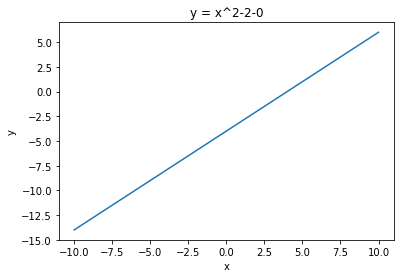

In [51]:
equation=equ
solver = Solver(equation)
solver.solveEquation()
Graph(solver.leftEqu)

## Remove the temporary png file from directory


In [52]:
import os 
os.remove("temp.png")